# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sb
sb.set_style(style='dark')

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Number of rows for general pop data: ', azdias.shape[0])
print('Number of columns for general pop data: ', azdias.shape[1])
azdias.head()

Number of rows for general pop data:  891221
Number of columns for general pop data:  85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# see first few rows of feature information
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# parsing values in the 'missing_or_unknown' column of feat_info df
# result: converting strings to lists with integers/strings

for index, row in feat_info.iterrows():
    new_val = row['missing_or_unknown']
    new_val = new_val.replace('[', '').replace(']', '')
    new_val = new_val.split(sep=',')
    new_val = [int(x) if (x!='X' and x!='XX' and x!='') else x for x in new_val]     
    row['missing_or_unknown'] = new_val


In [6]:
# set index of feat_info to be the attribute column
feat_info.set_index('attribute', inplace=True)
feat_info.head()

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1, 0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
ANREDE_KZ,person,categorical,"[-1, 0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
# Identify missing or unknown data values and convert them to NaNs.
# first: extract column names
columns = azdias.columns

# now: replace missing values codes with NaNs
for col in columns:
    azdias[col].replace(feat_info.loc[col, 'missing_or_unknown'], np.nan, inplace=True)
    

In [8]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Investigate patterns in the amount of missing data in each column.
original_missings = azdias.isnull().sum().sum()
print('Total number of missing values: ', original_missings)
#print(':::::::::')
#print('Number of missing values in each column:\n', azdias.isnull().sum())

Total number of missing values:  8373929


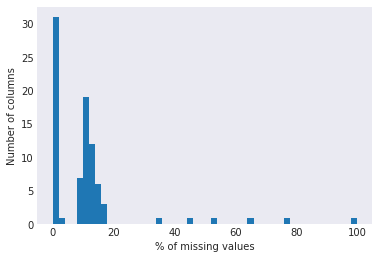

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# % of missing values in each column
percent_missing_per_col = (azdias.isnull().sum()/len(azdias))*100

# visualizing patterns of missing data
plt.hist(percent_missing_per_col, bins=50);
plt.xlabel('% of missing values');
plt.ylabel('Number of columns');

#### Looking at the graph, the majority of columns are below 20%

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
'''
outlier columns: those with 20%+ missing data
'''
outlier_cols = percent_missing_per_col[percent_missing_per_col>= 20]
outlier_cols

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

In [12]:
# retreiving the outlier columns names
print('Outlier columns: ', outlier_cols.index.tolist())

Outlier columns:  ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [13]:
# remove outlier columns
azdias.drop(outlier_cols.index.tolist(), axis=1, inplace=True)
azdias.shape

(891221, 79)

In [14]:
# new total number of missing values
new_missings = azdias.isnull().sum().sum()
print('Number of missing values after removing outlier columns: ', new_missings)

Number of missing values after removing outlier columns:  5035304


In [15]:
print('Number of columns with no missing vlues: ',len(percent_missing_per_col[percent_missing_per_col==0]))
print('Original total number of missing data: ', original_missings)
print('New total number of missing data: ', new_missings)
print('% change in terms of total number of missing values: %',((original_missings-new_missings)/original_missings)*100)

Number of columns with no missing vlues:  24
Original total number of missing data:  8373929
New total number of missing data:  5035304
% change in terms of total number of missing values: % 39.8692776115


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Observations:
1. Out of 85 columns, 24 have no missing vlues
2. The majority of columns had less than 20% of missing data
3. Using the arbitrary 20% threshold, outlier columns were identified (in terms of % of missing data)
4. 6 of 85 columns were considered outliers. One of them had almost no data at all (99.7% were missing)
5. Those 6 columns were removed
6. The 6 columns accounted for about 40% of the missing data in the original dataset


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

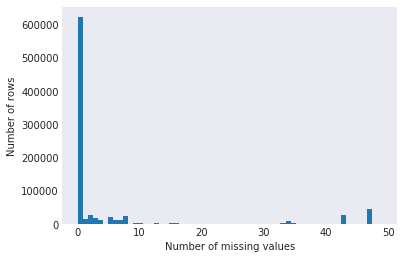

In [16]:
# How much data is missing in each row of the dataset?

# number of missing values in each row
number_missing_per_row = azdias.isnull().sum(axis=1)

# visualizing patterns of missing data 
plt.hist(number_missing_per_row, bins=60);
plt.xlabel('Number of missing values');
plt.ylabel('Number of rows');

In [17]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# arbitrary limit = 5
# data with fewer than 5 missing values in each row
azdias_fewer_5 = azdias[azdias.isnull().sum(axis=1) <= 5]

# data with more than 5 missing values in each row
azdias_more_5 = azdias[azdias.isnull().sum(axis=1) > 5]

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

no_missing = percent_missing_per_col[percent_missing_per_col==0].index.tolist()

# number of columns used for comparison
number_cols = 10

cols_to_compare = no_missing[:number_cols]

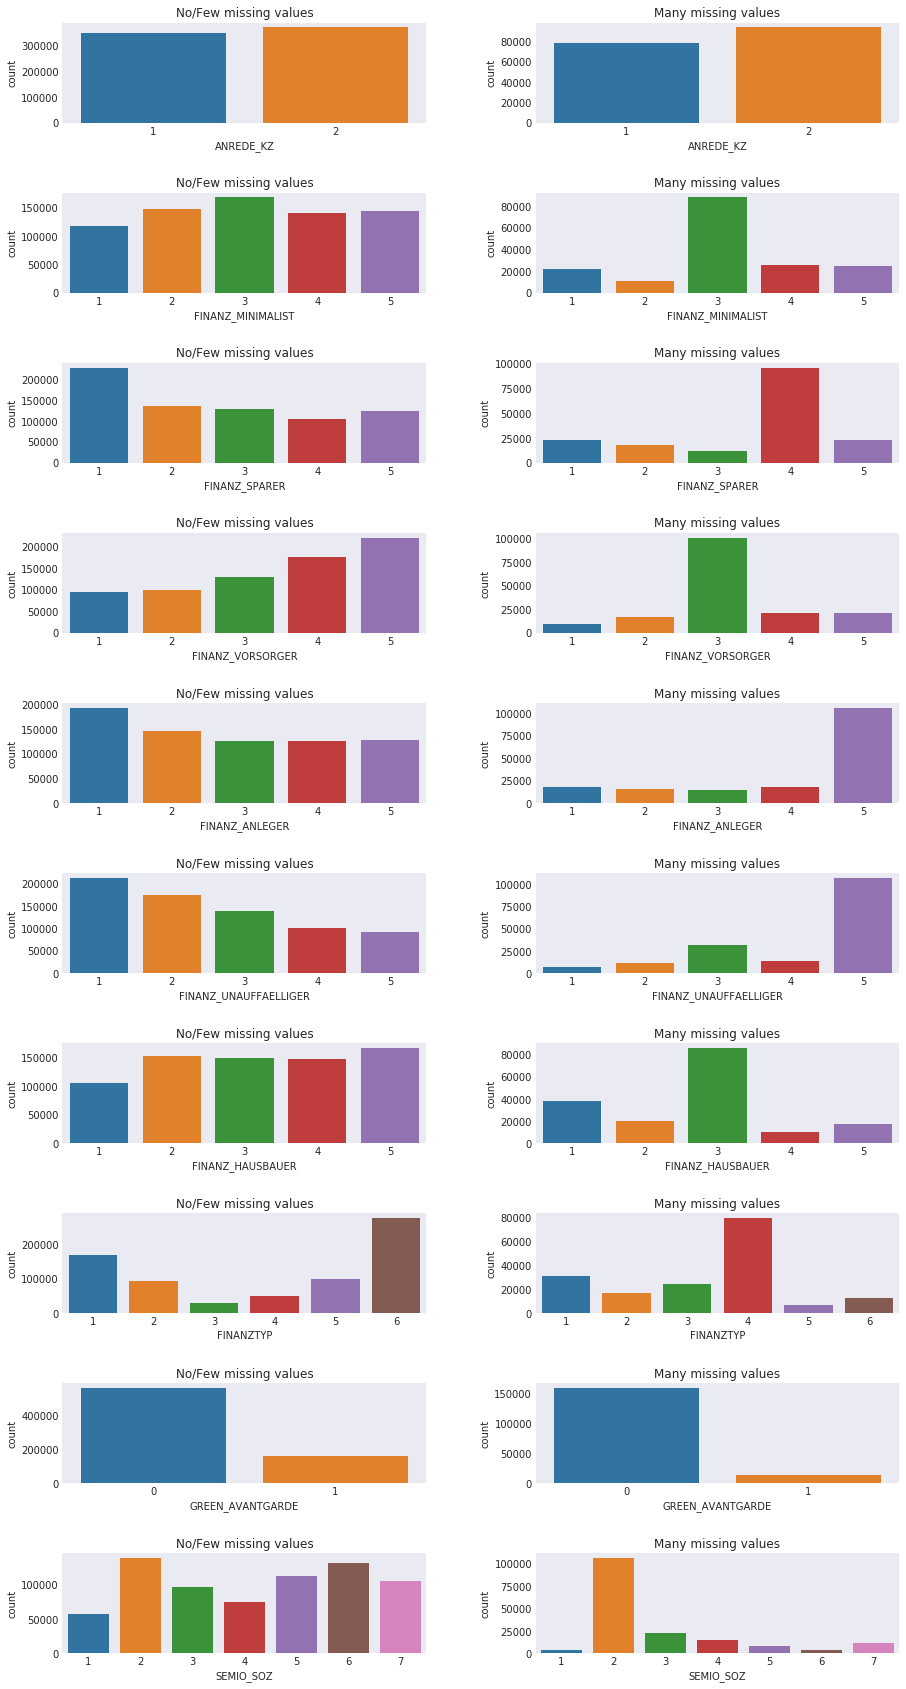

In [19]:
# create figure with subplots
figure, axs = plt.subplots(nrows=number_cols, ncols=2, figsize = (15,30))

# add margins between subplots
figure.subplots_adjust(hspace=.7, wspace=0.3)

for i in range(number_cols):
    sb.countplot(azdias_fewer_5[cols_to_compare[i]], ax=axs[i][0])
    axs[i][0].set_title('No/Few missing values')
    sb.countplot(azdias_more_5[cols_to_compare[i]], ax=axs[i][1])
    axs[i][1].set_title('Many missing values')


In [20]:
print('Number of rows for dataset with few missing values in its rows: ', len(azdias_fewer_5))
print('Number of rows for dataset with many missing values in its rows: ', len(azdias_more_5))

Number of rows for dataset with few missing values in its rows:  719624
Number of rows for dataset with many missing values in its rows:  171597


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

**Looking at the graphs, it's obvious that the distributions of features change significantly between rows without missing values and rows with many missing values (Except perhaps those attributes that are related to gender)**

**From now on, data with few missing values in rows will be used.**

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64


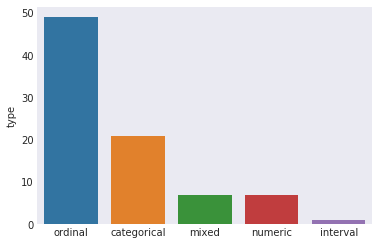

In [21]:
# How many features are there of each data type?

feat_types = feat_info['type'].value_counts()
print(feat_types)
sb.barplot(x = feat_types.index, y = feat_types);

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# identify categorical features
cat_features = feat_info[feat_info['type'] == 'categorical'].index.tolist()

# some of these features were dropped due to having many missing values

# removing outlier categorical features
categorical = list(set(cat_features) - set(outlier_cols.index.tolist()))
categorical

['NATIONALITAET_KZ',
 'GREEN_AVANTGARDE',
 'OST_WEST_KZ',
 'LP_STATUS_FEIN',
 'LP_FAMILIE_GROB',
 'FINANZTYP',
 'ZABEOTYP',
 'CJT_GESAMTTYP',
 'LP_FAMILIE_FEIN',
 'CAMEO_DEUG_2015',
 'GFK_URLAUBERTYP',
 'SHOPPER_TYP',
 'ANREDE_KZ',
 'GEBAEUDETYP',
 'LP_STATUS_GROB',
 'VERS_TYP',
 'CAMEO_DEU_2015',
 'SOHO_KZ']

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# create a dictionary describing categorical features
'''
the dictionary contains categorical features as its keys; the values are lists with two
items: 1- string describing the type of the categorical feature(binary or multi-level), 
and 2- a list containing the unique values of the categorical feature
'''

cat_info = {}
for feature in categorical:
    # get unique values (including nan)
    unique_nan = azdias[feature].unique()
    # remove nan if it's there
    unique = [x for x in unique_nan if not pd.isnull(x)]
    # variable indicating if feature is binary or multi-level
    feat_type = None
    if len(unique) > 2:
        feat_type = 'multi'
    else:
        feat_type = 'binary'
    cat_info[feature] = [feat_type, unique]

In [24]:
# uncomment to see contents of the created dictionary
#cat_info

In [25]:
# categorical variables to be re-encoded: all multi, except for 'CAMEO_DEU_2015' for 
# having too many values, and 'OST_WEST_KZ', which is binary with non-numeric values

to_re_encode = ['OST_WEST_KZ']

# adding multi-level categorical features
for feature, info in cat_info.items():
    if info[0] == 'multi' and feature != 'CAMEO_DEU_2015':
        to_re_encode.append(feature)
print('{} categorical features to be re-encoded'.format(len(to_re_encode)))

13 categorical features to be re-encoded


In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.
# data with few missing values in rows is used
features_cat_reencoded = pd.get_dummies(azdias_fewer_5, columns=to_re_encode)
print('Number of features after re-encoding categorical features: ', len(list(features_cat_reencoded.columns)))

Number of features after re-encoding categorical features:  152


In [27]:
features_cat_reencoded.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,1,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,1,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**1. I removed categorical features that were cosidered outlier in terms of the number of missing values they have.**

**2. I kept the binary ones with numeric values as is**

**3. I re-encoded the binary feature 'OST_WEST_KZ' which has non-numeric values**

**4. I kept and re-encoded all the multi-level categorical features, except for 'CAMEO_DEU_2015', which has too many values**

**5. I used `pd.get_dummies()` to re-encode the features**


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
# identify mixed features
mixed_features = feat_info[feat_info['type'] == 'mixed'].index.tolist()
mixed_features

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
features_cat_reencoded['DECADE'] = features_cat_reencoded['PRAEGENDE_JUGENDJAHRE']
features_cat_reencoded['MOVEMENT'] = features_cat_reencoded['PRAEGENDE_JUGENDJAHRE']

In [30]:
'''
There are six generations. Values to represent them are: 1 through 6.
The mapping of generations to values are as follows:
1: 40s, 2: 50s, 3: 60s, 4: 70s, 5: 80s, and 6: 90s
'''
decade_map = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
'''
There are two movements. Values to represent them are: 1 and 0.
The mapping of movements to values are as follows:
1: Mainstream, and 0: Avantgrade.
'''
movement_map = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [31]:
# modify the decade and movement columns; replcae current values with the appropriate ones
features_cat_reencoded['DECADE'].replace(decade_map, inplace=True)
features_cat_reencoded['MOVEMENT'].replace(movement_map, inplace=True)

In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
features_cat_reencoded['WEALTH'] = features_cat_reencoded['CAMEO_INTL_2015']
features_cat_reencoded['LIFE_STAGE'] = features_cat_reencoded['CAMEO_INTL_2015']

In [33]:
# mapping the new values of WEALTH and LIFE_STAGE columns to the current values
wealth_map = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
              '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
              '51':5, '52':5, '53':5, '54':5, '55':5}
life_stage_map = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                  '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                  '51':1, '52':2, '53':3, '54':4, '55':5}

In [34]:
features_cat_reencoded['WEALTH'].replace(wealth_map, inplace=True)
features_cat_reencoded['LIFE_STAGE'].replace(life_stage_map, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

1. I identified the mixed features
2. I created two variables: DECADE, and MOVEMENT to replace 'PRAEGENDE_JUGENDJAHRE'
3. I created two variables: WEALTH, and LIFE_STAGE to replace 'CAMEO_INTL_2015'
4. For each of the created variables, I created a dictionary that maps new to old values
5. I used the dictionaries to replace old values with new ones
6. I dismissed all other mixed features

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [35]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [36]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# copy the dataframe
final_data = pd.DataFrame(data = features_cat_reencoded)

# removing 'KBA05_BAUMAX' from the mixed_features list since it's not in the data
mixed_features.remove('KBA05_BAUMAX')

# drop the original mixed-type features
final_data.drop(mixed_features, axis = 1, inplace=True)
final_data.shape

(719624, 150)

In [37]:
# dropping the categorical feature 'CAMEO_DEU_2015' (as decided before)
final_data.drop('CAMEO_DEU_2015', axis = 1, inplace=True)

In [38]:
final_data.shape

(719624, 149)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def cleandata(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data. Assume feat_info dataframe is already defined and processed.
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # first: extract column names
    columns = df.columns

    # now: replace missing values codes with NaNs
    for col in columns:
        df[col].replace(feat_info.loc[col, 'missing_or_unknown'], np.nan, inplace=True)
 
    
    # remove selected columns and rows, ...
    

    # identify outlier columns, i.e. 20%+ missing values
    outlier_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    # remove outlier columns
    df.drop(outlier_cols, axis=1, inplace=True)
    
    # number of missing values in each row
    #number_missing_per_row = df.isnull().sum(axis=1)
    # keep data with fewer than 5 missing values in each row
    df_fewer_5 = df[df.isnull().sum(axis=1) <= 5]
    
    
    # select, re-encode, and engineer column values.
    
    # re-encode categorical variables
    # identify categorical features
    cat_features = feat_info[feat_info['type'] == 'categorical'].index.tolist()

    # some of these features could have been dropped due to having many missing values
    # removing outlier categorical features
    categorical = list(set(cat_features) - set(outlier_cols))
    
    cat_info = {}
    for feature in categorical:   
        # get unique values (including nan)
        unique_nan = df[feature].unique()
        # remove nan if it's there
        unique = [x for x in unique_nan if not pd.isnull(x)]
        # variable indicating if feature is binary or multi-level
        feat_type = None
        if len(unique) > 2:
            feat_type = 'multi'
        else:
            feat_type = 'binary'
        cat_info[feature] = [feat_type, unique]
        
    # categorical variables to be re-encoded: all multi, except for 'CAMEO_DEU_2015' for 
    # having too many values, and 'OST_WEST_KZ', which is binary with non-numeric values

    to_re_encode = ['OST_WEST_KZ']

    # adding multi-level categorical features
    for feature, info in cat_info.items():
        if info[0] == 'multi' and feature != 'CAMEO_DEU_2015':
            to_re_encode.append(feature)
    
    features_cat_reencoded = pd.get_dummies(df_fewer_5, columns=to_re_encode)
    
    # engineering mixed features
    features_cat_reencoded['DECADE'] = features_cat_reencoded['PRAEGENDE_JUGENDJAHRE']
    features_cat_reencoded['MOVEMENT'] = features_cat_reencoded['PRAEGENDE_JUGENDJAHRE']

    decade_map = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

    movement_map = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    features_cat_reencoded['DECADE'].replace(decade_map, inplace=True)
    features_cat_reencoded['MOVEMENT'].replace(movement_map, inplace=True)
    
    features_cat_reencoded['WEALTH'] = features_cat_reencoded['CAMEO_INTL_2015']
    features_cat_reencoded['LIFE_STAGE'] = features_cat_reencoded['CAMEO_INTL_2015']
    wealth_map = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
                  '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
                  '51':5, '52':5, '53':5, '54':5, '55':5}
    life_stage_map = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                      '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                      '51':1, '52':2, '53':3, '54':4, '55':5}
    features_cat_reencoded['WEALTH'].replace(wealth_map, inplace=True)
    features_cat_reencoded['LIFE_STAGE'].replace(life_stage_map, inplace=True)
    
    # copy the dataframe
    final_data = pd.DataFrame(data = features_cat_reencoded)
    
    
    # dropping mixed features
    mixed_features = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE',
                      'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']
    final_data.drop(mixed_features, axis = 1, inplace=True)
    
    # dropping the categorical feature 'CAMEO_DEU_2015' (due to having too many values)
    final_data.drop('CAMEO_DEU_2015', axis = 1, inplace=True)
    
    

    
    # Return the cleaned dataframe.
    return final_data
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [40]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# total number of missing data in the cleaned dataset
print('Number of missing values in the clean dataset: ', final_data.isnull().sum().sum())

# number of columns that contain nans
print('Number of columns with at least one missing value: ', final_data.isnull().any().sum())

# number of rows that contain nans
print('Number of rows with at least one missing value: ', final_data.isnull().any(axis=1).sum())

Number of missing values in the clean dataset:  185269
Number of columns with at least one missing value:  21
Number of rows with at least one missing value:  96413


In [41]:
# deleting rows with at least one missing values
clean_data = final_data.dropna(axis = 0)
clean_data.shape

(623211, 149)

In [42]:
# check if any nans exist in the clean dataset
clean_data.isnull().sum().sum()

0

**It turned out that the column `'GEBAEUDETYP_5.0'` will not be in the customers processed data after cleanining it below. This causes the customers clean data to have one fewer column than the general population data (148 vs. 149). So, I decided to drop this column here before applying the PCA to make sure the PCA object have the same number of features. After all, this column is not important in the analysis**

In [43]:
clean_data.drop('GEBAEUDETYP_5.0', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [44]:
# Apply feature scaling to the general population demographics data.


# define a scaler
scaler = StandardScaler()

# scale the data
scaled_data = scaler.fit_transform(clean_data)

# create a dataframe for scaled data
scaled_data_df = pd.DataFrame(scaled_data)
scaled_data_df.columns = clean_data.columns


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Here is what I did to scale the data:

1. First I investigated the number of missing values in total; number of columns with missing values; and number of rows with missing values
2. Since the number of columns containing missing values is relatively large, I decided not to remove the columns with missing values because some of the features could be important for the analysis
3. I deleted all the rows with missing values bucause the dataset is sufficiently large even after eliminating these rows
4. I used a standard scaler to scale the clean data
5. I created a dataframe for the scaled data just in case I need it in the upcoming steps

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [45]:
# define a function to do PCA

def do_pca(data, n_components=None):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    
    INPUT:  data - the data you would like to transform (scaled data)
            n_components - int - the number of principal components to create (default = None)   
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    #X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [46]:
# Apply PCA to the data.
pop_pca, pop_X_pca = do_pca(scaled_data_df)

#### Investigating variance vs. number of components

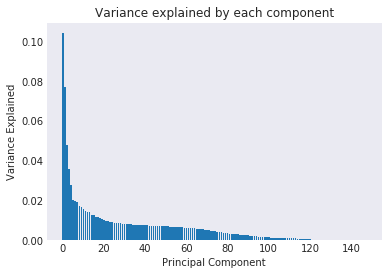

In [47]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pop_pca.explained_variance_ratio_)), pop_pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.show()

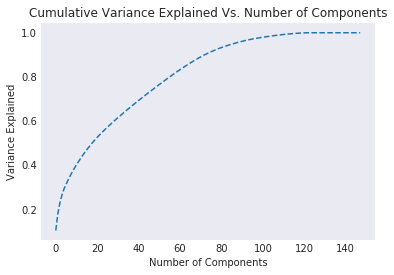

In [48]:
# investigating the total variance explained for each number of components
plt.plot(range(len(pop_pca.explained_variance_ratio_)), np.cumsum(pop_pca.explained_variance_ratio_),
         linestyle='--');
plt.xlabel('Number of Components');
plt.ylabel('Variance Explained');
plt.title('Cumulative Variance Explained Vs. Number of Components');
plt.show();

In [49]:
# returning the position where cumulative variance exceeds 80%
np.argmax(np.cumsum(pop_pca.explained_variance_ratio_)>0.8)

55

#### 80% of variability in the data can be explained by only 56 components

In [50]:
# Re-apply PCA to the data while selecting for number of components to retain.
pop_pca_56, pop_X_pca_56 = do_pca(scaled_data_df, 56)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Here is what I did:

1. I did a PCA analysis on the full dataset (140+ components) to see trends in variability among the features
2. I found that 80% of the variability are explained by only 56 components (only 38% of the data)
3. I re-did PCA with a number of components = 56

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [51]:
def feature_weights(pca, i):
    '''
    Returns the weights of all features for a given component i
    Inputs: 1- pca: PCA object
            2- i: i'th component 
    Output: a pandas series containing the weights in descending order
    '''
    df = pd.DataFrame(pca.components_, columns=list(scaled_data_df.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

In [52]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
print(feature_weights(pop_pca_56, 0))

LP_STATUS_GROB_1.0      0.194619
HH_EINKOMMEN_SCORE      0.181201
PLZ8_ANTG3              0.175457
WEALTH                  0.175064
PLZ8_ANTG4              0.170351
ORTSGR_KLS9             0.147327
EWDICHTE                0.144613
FINANZ_SPARER           0.140605
FINANZ_HAUSBAUER        0.136326
KBA05_ANTG4             0.124700
FINANZTYP_1             0.123869
LP_STATUS_FEIN_1.0      0.121898
LP_STATUS_FEIN_2.0      0.121756
PLZ8_ANTG2              0.116033
KBA05_ANTG3             0.115117
MOVEMENT                0.113099
ANZ_HAUSHALTE_AKTIV     0.112694
ARBEIT                  0.111408
CAMEO_DEUG_2015_9       0.108055
SEMIO_PFLICHT           0.106597
DECADE                  0.104258
SEMIO_REL               0.100419
RELAT_AB                0.100125
SEMIO_TRADV             0.095132
SEMIO_RAT               0.091196
ZABEOTYP_5              0.088844
CAMEO_DEUG_2015_8       0.086577
LP_FAMILIE_GROB_1.0     0.086082
LP_FAMILIE_FEIN_1.0     0.086082
FINANZ_ANLEGER          0.078618
          

In [53]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(feature_weights(pop_pca_56, 1))

ALTERSKATEGORIE_GROB     0.222234
FINANZ_VORSORGER         0.200624
ZABEOTYP_3               0.198478
SEMIO_ERL                0.180481
RETOURTYP_BK_S           0.155593
SEMIO_LUST               0.152518
W_KEIT_KIND_HH           0.131699
LP_STATUS_FEIN_1.0       0.114279
FINANZ_HAUSBAUER         0.105883
CJT_GESAMTTYP_2.0        0.097879
PLZ8_ANTG3               0.092071
FINANZTYP_5              0.091429
PLZ8_ANTG4               0.087920
SEMIO_KRIT               0.085980
ORTSGR_KLS9              0.083770
EWDICHTE                 0.083676
WEALTH                   0.079175
LP_FAMILIE_GROB_1.0      0.077194
LP_FAMILIE_FEIN_1.0      0.077194
FINANZTYP_2              0.073164
SHOPPER_TYP_3.0          0.071167
KBA05_ANTG4              0.066835
CJT_GESAMTTYP_1.0        0.066483
SEMIO_KAEM               0.066443
ARBEIT                   0.065778
FINANZTYP_6              0.064010
PLZ8_ANTG2               0.060813
ANZ_HAUSHALTE_AKTIV      0.060571
RELAT_AB                 0.059764
HH_EINKOMMEN_S

In [54]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(feature_weights(pop_pca_56, 2))

SEMIO_VERT               0.321347
SEMIO_FAM                0.259270
SEMIO_SOZ                0.256368
SEMIO_KULT               0.244780
FINANZTYP_5              0.139250
FINANZ_MINIMALIST        0.127894
SHOPPER_TYP_0.0          0.126833
SEMIO_REL                0.117140
ZABEOTYP_1               0.115469
RETOURTYP_BK_S           0.085617
SEMIO_MAT                0.080038
W_KEIT_KIND_HH           0.075367
GREEN_AVANTGARDE         0.073732
EWDICHTE                 0.067047
ORTSGR_KLS9              0.066022
ZABEOTYP_6               0.052544
PLZ8_ANTG4               0.051160
PLZ8_ANTG3               0.050817
LP_STATUS_FEIN_10.0      0.050120
LP_STATUS_GROB_5.0       0.050120
FINANZ_VORSORGER         0.049799
LP_STATUS_FEIN_1.0       0.046326
LP_STATUS_FEIN_3.0       0.045953
SHOPPER_TYP_1.0          0.044701
PLZ8_ANTG2               0.036938
RELAT_AB                 0.035610
GEBAEUDETYP_3.0          0.033178
SEMIO_LUST               0.033152
ARBEIT                   0.032492
LP_STATUS_GROB

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

1. Component 1: top 3 positive values are for: LP_STATUS_GROB_1.0 with 0.19 (Social status), HH_EINKOMMEN_SCORE with 0.18 (Household income), and PLZ8_ANTG3 with 0.17 (Number of 6-10 family houses). Top 3 -ve values are for: FINANZ_MINIMALIST with -0.20, MOBI_REGIO with -0.20, and KBA05_ANTG1 with -0.19. We can say that this component has to do with peronal- and household level features such as income.

2. Component 2: top 3 positive values are for: ALTERSKATEGORIE_GROB with 0.22, FINANZ_VORSORGER with 0.20, ZABEOTYP_3 wtih 0.19. Top 3 negative values are for: FINANZ_SPARER with -0.20, SEMIO_REL with -0.212170, DECADE with -0.22.

3. Component 3: top 3 positive values are for: SEMIO_VERT with 0.32, SEMIO_FAM with 0.25, and SEMIO_SOZ with 0.25. Top 3 negative values are for: SEMIO_DOM with -0.28, SEMIO_KAEM with -0.31, and ANREDE_KZ with -0.34.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [55]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score 

#### Note: I ran the for loop in the cell below once and then extracted the values from the `scores` list and saved them so that I don't need to run the loop again every time I come back to the project because the loop takes a long time to run.

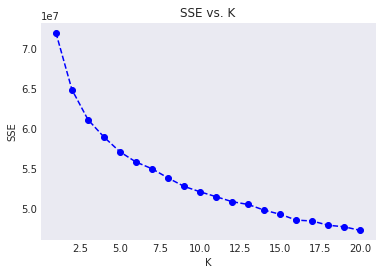

In [56]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

scores = [72041961.570956007, 64894727.399251655, 61133786.866023369, 58942826.178062454,
          57084853.22931131, 55804796.042360209, 54962580.054987855, 53802373.903760076,
          52749219.559744269, 52065610.40937008, 51454190.258109137, 50827769.26107464,
          50477720.724926762, 49764226.396840371, 49245104.595430978, 48517830.661698155,
          48397470.061569944, 47868609.131439149, 47672736.649909973, 47218803.987558521]

centers = list(range(1, 21))
'''
for center in centers:
    scores.append(get_kmeans_score(pop_X_pca_56, center))
'''

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [57]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_16 = KMeans(n_clusters=16)
model_16 = kmeans_16.fit(pop_X_pca_56)
pop_preds = model_16.predict(pop_X_pca_56)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

When k, number of clusters, is 16, the reduction in SSE is small. So, k = 16 seems to be appropriate. Therefore, I chose the number of clusters to be 16.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [58]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [59]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_final = cleandata(customers)

In [60]:
# dropping rows with at least one missing value
customers_clean = customers_final.dropna(axis = 0)

In [61]:
# Apply feature scaling to the customers demographics data.

# scale the data
customers_scaled_data = scaler.fit_transform(customers_clean)

# create a dataframe for scaled data
costomers_scaled_data_df = pd.DataFrame(customers_scaled_data)
costomers_scaled_data_df.columns = customers_clean.columns

In [62]:
# applying PCA transformation to customers scaled data
customers_X_pca_56 = pop_pca_56.transform(costomers_scaled_data_df)

In [63]:
customers_preds = model_16.predict(customers_X_pca_56)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

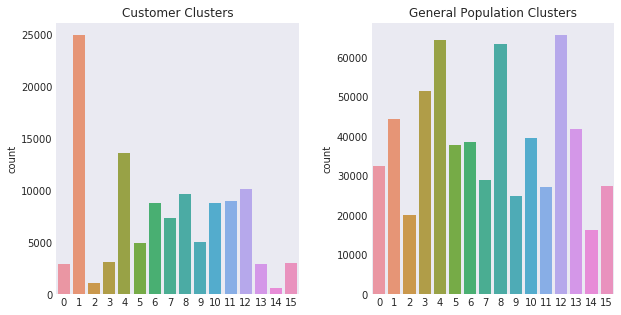

In [64]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sb.countplot(customers_preds, ax=axs[0]);
axs[0].set_title('Customer Clusters');
sb.countplot(pop_preds, ax=axs[1]);
axs[1].set_title('General Population Clusters');

In [71]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_1 = scaler.inverse_transform(pop_pca_56.inverse_transform(model_16.cluster_centers_[1]))

In [72]:
over_represented = pd.Series(data = cluster_1, index=customers_final.columns, name='over_represented')
over_represented

ALTERSKATEGORIE_GROB     3.776678
ANREDE_KZ                0.888984
FINANZ_MINIMALIST        5.552867
FINANZ_SPARER            0.953701
FINANZ_VORSORGER         4.946439
FINANZ_ANLEGER           0.841032
FINANZ_UNAUFFAELLIGER    1.611579
FINANZ_HAUSBAUER         1.517832
GREEN_AVANTGARDE         1.452225
HEALTH_TYP               1.780629
RETOURTYP_BK_S           4.180173
SEMIO_SOZ                5.320446
SEMIO_FAM                4.629855
SEMIO_REL                3.233852
SEMIO_MAT                3.453508
SEMIO_VERT               6.969988
SEMIO_LUST               6.215906
SEMIO_ERL                4.225468
SEMIO_KULT               4.788300
SEMIO_RAT                1.968473
SEMIO_KRIT               2.378260
SEMIO_DOM                2.854359
SEMIO_KAEM               1.877380
SEMIO_PFLICHT            2.434578
SEMIO_TRADV              2.539818
SOHO_KZ                 -0.004172
VERS_TYP                 1.452562
ANZ_PERSONEN             3.032760
ANZ_TITEL                0.002538
HH_EINKOMMEN_S

In [73]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_3 = scaler.inverse_transform(pop_pca_56.inverse_transform(model_16.cluster_centers_[3]))

In [74]:
under_represented = pd.Series(data = cluster_3, index=customers_final.columns, name='under_represented')
under_represented

ALTERSKATEGORIE_GROB     2.711231
ANREDE_KZ                1.805390
FINANZ_MINIMALIST        2.823811
FINANZ_SPARER            2.330870
FINANZ_VORSORGER         3.796456
FINANZ_ANLEGER           2.531238
FINANZ_UNAUFFAELLIGER    2.568772
FINANZ_HAUSBAUER         3.907097
GREEN_AVANTGARDE         0.295582
HEALTH_TYP               1.931222
RETOURTYP_BK_S           3.064659
SEMIO_SOZ                3.620123
SEMIO_FAM                3.664971
SEMIO_REL                4.197257
SEMIO_MAT                4.501981
SEMIO_VERT               3.302022
SEMIO_LUST               4.338335
SEMIO_ERL                4.407493
SEMIO_KULT               3.933706
SEMIO_RAT                4.788881
SEMIO_KRIT               4.828664
SEMIO_DOM                5.478841
SEMIO_KAEM               5.448318
SEMIO_PFLICHT            4.483624
SEMIO_TRADV              4.535813
SOHO_KZ                  0.004516
VERS_TYP                 1.405967
ANZ_PERSONEN             2.055905
ANZ_TITEL                0.009901
HH_EINKOMMEN_S

In [75]:
# concatenating the two series in a dataframe
comparison = pd.concat([over_represented, under_represented], axis=1)
comparison.head()

,over_represented,under_represented
ALTERSKATEGORIE_GROB,3.776678,2.711231
ANREDE_KZ,0.888984,1.805390
FINANZ_MINIMALIST,5.552867,2.823811
FINANZ_SPARER,0.953701,2.330870
FINANZ_VORSORGER,4.946439,3.796456


In [76]:
# Describing the customers of the mail-order company in terms of a subset of
# the demographic features

features_to_compare = {'WEALTH': 'Status of individual wealth', 'KONSUMNAEHE': 'Distance from building to point of sale (PoS)',
                       'ALTERSKATEGORIE_GROB': 'Estimated age based on name', 
                       'LIFE_STAGE': 'Individual life stage', 'EWDICHTE': 'Density of households per square kilometer',
                       'MOVEMENT': 'Dominating movement of persons youth (avantgarde vs. mainstream)',
                       'INNENSTADT': 'Distance to downtown', 'PLZ8_ANTG3': 'Number of 6-10 family houses in the PLZ8 region'}

for feat, description in features_to_compare.items():
    print('Feature: ', feat, '\nDescription: ', description)
    print('Over-Represented: ', comparison.loc[feat, 'over_represented'], '\t', 'Under-Represented: ', 
          comparison.loc[feat, 'under_represented'])
    print('::::::::::::::::::')
    

Feature:  WEALTH 
Description:  Status of individual wealth
Over-Represented:  1.4250976169 	 Under-Represented:  3.72482988464
::::::::::::::::::
Feature:  KONSUMNAEHE 
Description:  Distance from building to point of sale (PoS)
Over-Represented:  3.58364083053 	 Under-Represented:  2.21773715873
::::::::::::::::::
Feature:  ALTERSKATEGORIE_GROB 
Description:  Estimated age based on name
Over-Represented:  3.77667843639 	 Under-Represented:  2.71123096508
::::::::::::::::::
Feature:  LIFE_STAGE 
Description:  Individual life stage
Over-Represented:  4.02370389063 	 Under-Represented:  2.57795969007
::::::::::::::::::
Feature:  EWDICHTE 
Description:  Density of households per square kilometer
Over-Represented:  3.74229057461 	 Under-Represented:  5.10717580625
::::::::::::::::::
Feature:  MOVEMENT 
Description:  Dominating movement of persons youth (avantgarde vs. mainstream)
Over-Represented:  -0.452224699107 	 Under-Represented:  0.704418234322
::::::::::::::::::
Feature:  INNENSTAD

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Customers of the mail-order company are (compared to other segments of the population): more affluent (WEALTH = 1.4); tend to be older (families with children or older families; LIFE STAGE = 4); tend to live farther from downtown (INNENSTADT = 5); tend to live relatively far away from a Point of Sale (KONSUMNAEHE = 3.5); and tend to live in less densely populated areas (EWDICHTE = 3.7).

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.